# DeepFace Analysis

In [223]:
import itertools
import json
import os
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

import pandas as pd

from tqdm import tqdm

import cv2 as cv
import numpy as np
import sklearn
from sklearn import base, calibration, metrics, model_selection

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

In [2]:
backend = 'mtcnn'
predictions_path = os.path.join('../images/processed', f'deepface_{backend}.json')

with open(predictions_path, 'r') as fp:
    predictions = json.load(fp)
    
pprint(f'Predictions for {len(predictions)} images')

'Predictions for 27 images'


In [3]:
images_root = '../images/raw'

via_project_path = os.path.join(images_root, 'via_project_13Sep2022_19h41m.json')

In [4]:
with open(via_project_path, 'r') as f:
    via_project = json.load(f)
    
via_images = via_project['_via_image_id_list']
via_metadata = via_project['_via_img_metadata']

In [5]:
via_img = via_images[0]
img_metadata = via_metadata[via_img]

img_path = os.path.join(images_root, img_metadata['filename'])
img_regions = img_metadata['regions']
print(f'Image annotations: {img_path}')
pprint(img_metadata)

Image annotations: ../images/raw\vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png
{'file_attributes': {'height': '512', 'width': '512'},
 'filename': 'vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png',
 'regions': [{'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 175,
                                   'name': 'rect',
                                   'width': 134,
                                   'x': 66,
                                   'y': 21}},
             {'region_attributes': {'gender': 'Man'},
              'shape_attributes': {'height': 124,
                                   'name': 'rect',
                                   'width': 93,
                                   'x': 338,
                                   'y': 43}},
             {'region_attributes': {'gender': 'Woman'},
              'shape_attributes': {'height': 187,
                                   'name': 'rect',
           

In [6]:
def region_bbox(region: dict) -> List[int]:
    shape = region['shape_attributes']
    bbox = [
        shape['x'],
        shape['y'],
        shape['x'] + shape['width'],
        shape['y'] + shape['height']
    ]
    return bbox

In [7]:
def image_size(img_metadata: dict) -> Tuple[int, int]:
    width = int(img_metadata['file_attributes']['width'])
    height = int(img_metadata['file_attributes']['height'])
    return (width, height)

def region_labels(region: dict) -> dict:
    labels = region['region_attributes'].copy()
    labels['bbox'] = region_bbox(region)
    return labels

def image_labels(img_metadata: dict) -> List[Optional[dict]]:
    width, height = image_size(img_metadata)
    quadrants = sort_regions((width, height), img_metadata['regions'])
    labels = [region_labels(region) if region else None for region in quadrants] 
    return {
        'filename': img_metadata['filename'],
        'labels': labels
    }

def project_labels(via_project: dict) -> List[Tuple[str, List[Optional[dict]]]]:
    img_metadata = via_project['_via_img_metadata']
    return list(map(lambda id: image_labels(img_metadata[id]), via_project['_via_image_id_list']))

In [8]:
def sort_regions(img_size: Tuple[int, int], regions: dict) -> dict:
    width, height = [d // 2 for d in img_size]
    def region_index(r):
        index = (r['shape_attributes']['x']//width << 1) + r['shape_attributes']['y']//height
        return index
            
    quadrants = [None]*4
    for region in regions:
        idx = region_index(region)
        quadrants[idx] = region
        
    return quadrants

In [9]:
print('Unsorted')
pprint(img_regions)

print('Sorted')
pprint(sort_regions(image_size(img_metadata), img_regions))

Unsorted
[{'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 175,
                       'name': 'rect',
                       'width': 134,
                       'x': 66,
                       'y': 21}},
 {'region_attributes': {'gender': 'Man'},
  'shape_attributes': {'height': 124,
                       'name': 'rect',
                       'width': 93,
                       'x': 338,
                       'y': 43}},
 {'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 187,
                       'name': 'rect',
                       'width': 153,
                       'x': 47,
                       'y': 257}}]
Sorted
[{'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 175,
                       'name': 'rect',
                       'width': 134,
                       'x': 66,
                       'y': 21}},
 {'region_attributes': {'gender': 'Woman'},
  'shape_attributes': {'height': 187,
       

In [10]:
labels = project_labels(via_project)
pprint(labels[:5])

[{'filename': 'vroz_citizen_photorealistic_703c6fc2-d66d-4ed2-8966-259caa4cf064.png',
  'labels': [{'bbox': [66, 21, 200, 196], 'gender': 'Woman'},
             {'bbox': [47, 257, 200, 444], 'gender': 'Woman'},
             {'bbox': [338, 43, 431, 167], 'gender': 'Man'},
             None]},
 {'filename': 'vroz_sophisticated_person_photorealistic_c35401e3-d9ac-4403-80a2-9f9cd81802bd.png',
  'labels': [{'bbox': [64, 20, 193, 218], 'gender': 'Woman'},
             {'bbox': [95, 273, 178, 402], 'gender': 'Woman'},
             {'bbox': [330, 25, 418, 147], 'gender': 'Woman'},
             {'bbox': [326, 307, 438, 461], 'gender': 'Woman'}]},
 {'filename': 'vroz_authoritarian_person_photorealistic_53affad0-ebd9-44b4-a9ac-7b24597b3803.png',
  'labels': [{'bbox': [94, 8, 147, 80], 'gender': 'Man'},
             {'bbox': [82, 281, 173, 404], 'gender': 'Man'},
             {'bbox': [321, 10, 455, 209], 'gender': 'Man'},
             {'bbox': [341, 273, 449, 444], 'gender': 'Man'}]},
 {'filename

In [11]:
predictions_detect = list(map(lambda p: 1 if p else 0, itertools.chain.from_iterable(map(lambda image: image['predictions'], predictions))))

labels_detect = list(map(lambda p: 1 if p else 0, itertools.chain.from_iterable(map(lambda image: image['labels'], labels))))

In [12]:
print(metrics.classification_report(labels_detect, predictions_detect, target_names=['no detect', 'detect']))

              precision    recall  f1-score   support

   no detect       1.00      1.00      1.00        14
      detect       1.00      1.00      1.00        94

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



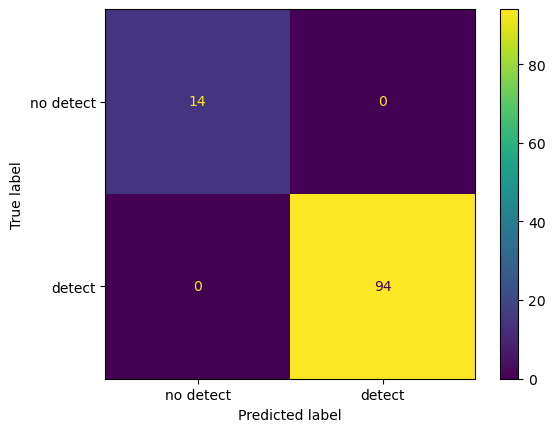

In [13]:
cm = metrics.confusion_matrix(labels_detect, predictions_detect)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no detect', 'detect'])
disp.plot()

In [14]:
predictions_bboxes = list(map(lambda p: p['bbox'] if p else None, itertools.chain.from_iterable(map(lambda image: image['predictions'], predictions))))

labels_bboxes = list(map(lambda p: p['bbox'] if p else None, itertools.chain.from_iterable(map(lambda image: image['labels'], labels))))

In [15]:
def iou_score(bbox1: List[int], bbox2: List[int]) -> float:
    ab = np.stack([np.array(bbox1), np.array(bbox2)]).astype('float32')
    intersect = np.maximum(ab[:, [2, 3]].min(axis=0) - ab[:, [0, 1]].max(axis=0), 0).prod()
    union = ((ab[:, 2] - ab[:, 0]) * (ab[:, 3] - ab[:, 1])).sum() - intersect
    return intersect / union

iou_score([0, 0, 256, 256], [256//4, 256//4, 3*256//4, 3*256//4])

0.25

(array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  2.,  3.,  4.,
         8.,  7., 12., 10.,  6., 10., 14.,  7.,  4.,  3.,  0.,  0.]),
 array([0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
        0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92,
        0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 25 artists>)

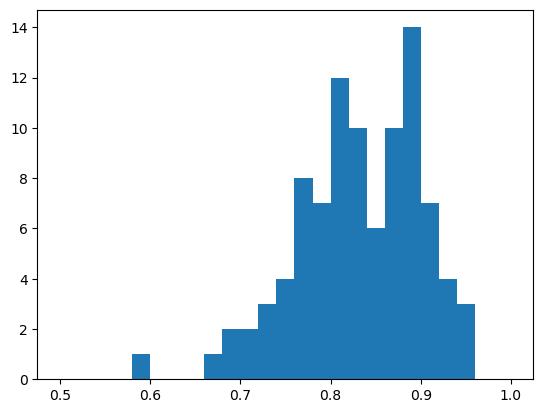

In [16]:
plt.hist(list(map(lambda bboxes: iou_score(*bboxes), filter(lambda bboxes: all(bboxes), zip(labels_bboxes, predictions_bboxes)))),
        range=(0.5, 1.0),
        bins=25)

In [225]:
threshold = 0.5

predictions_gender = list(map(lambda p: (p['gender']['Man']/100, 1 if p['gender']['Man']/100 >= threshold else 0) if p else None,
                              itertools.chain.from_iterable(map(lambda image: image['predictions'], predictions))))

labels_gender = list(map(lambda p: (1 if p['gender'] == 'Man' else 0) if p else None, itertools.chain.from_iterable(map(lambda image: image['labels'], labels))))

labels_gender, predictions_gender = zip(*list(filter(lambda p: p[0] is not None and p[1] is not None, zip(labels_gender, predictions_gender))))
labels_gender = list(labels_gender)

In [226]:
print(metrics.classification_report(labels_gender, [p[1] for p in predictions_gender], target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.97      0.57      0.72        49
         Man       0.68      0.98      0.80        45

    accuracy                           0.77        94
   macro avg       0.82      0.77      0.76        94
weighted avg       0.83      0.77      0.76        94



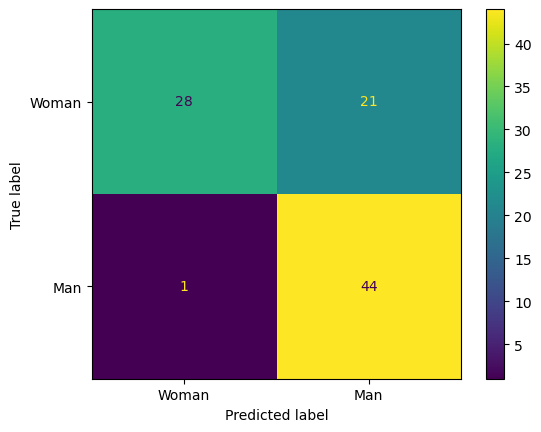

In [227]:
cm = metrics.confusion_matrix(labels_gender, [p[1] for p in predictions_gender])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Woman', 'Man'])
disp.plot()

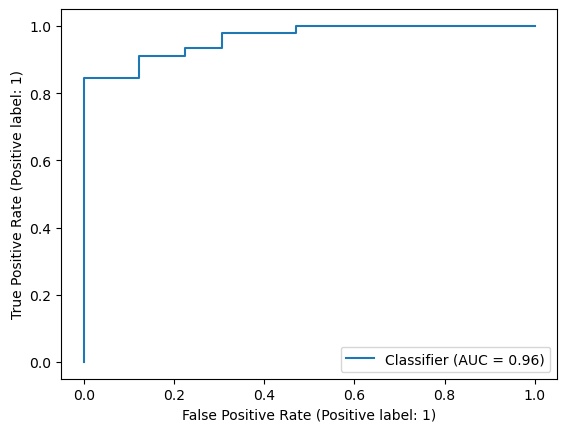

In [228]:
disp = metrics.RocCurveDisplay.from_predictions(labels_gender, [p[0] for p in predictions_gender])
disp

(array([25.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  5.,  0.,  2.,  2.,  6., 48.]),
 array([4.07444105e-07, 5.00003871e-02, 1.00000367e-01, 1.50000346e-01,
        2.00000326e-01, 2.50000306e-01, 3.00000285e-01, 3.50000265e-01,
        4.00000244e-01, 4.50000224e-01, 5.00000204e-01, 5.50000183e-01,
        6.00000163e-01, 6.50000143e-01, 7.00000122e-01, 7.50000102e-01,
        8.00000081e-01, 8.50000061e-01, 9.00000041e-01, 9.50000020e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

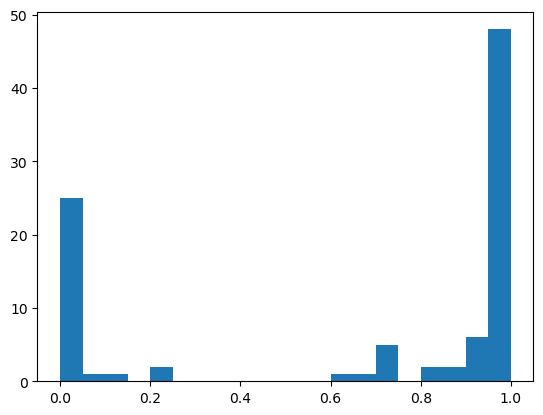

In [258]:
plt.hist([p[0] for p in predictions_gender], bins=20)

## Gender classifier calibration

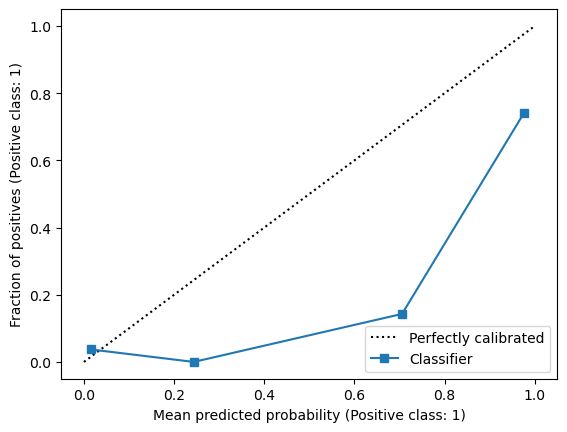

In [229]:
disp = calibration.CalibrationDisplay.from_predictions(labels_gender, [p[0] for p in predictions_gender], n_bins=5)
disp

In [224]:
labels_gender

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [240]:
predictions_gender_train, predictions_gender_test, labels_gender_train, labels_gender_test = model_selection.train_test_split(
    predictions_gender, labels_gender,
    test_size=0.33,
    stratify=labels_gender,
    random_state=42)

In [241]:
class IdentityClassifier(base.TransformerMixin, base.ClassifierMixin, base.BaseEstimator):
    def __init__(self, threshold):
        super().__init__()
        self.classes_ = np.array(range(0, 2))
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def predict_proba(self, X):
        return np.stack((1-X, X), axis=1)
    
    def predict(self, X):
        return np.array([1 if x >= self.threshold else 0 for x in X])

In [242]:
base_clf = IdentityClassifier(threshold=0.5)
base_clf.predict_proba(np.array([p[0] for p in predictions_gender_train])).shape

(62, 2)

In [253]:
calibrated_clf = calibration.CalibratedClassifierCV(base_estimator=base_clf, method='isotonic', cv='prefit')
calibrated_clf.fit(np.array([p[0] for p in predictions_gender_train]), np.array(labels_gender_train))

CalibratedClassifierCV(base_estimator=IdentityClassifier(threshold=0.5),
                       cv='prefit', method='isotonic')

In [254]:
print(metrics.classification_report(labels_gender_test,
                                    calibrated_clf.predict(np.array([p[0] for p in predictions_gender_test])),
                                    target_names=['Woman', 'Man']))

              precision    recall  f1-score   support

       Woman       0.81      1.00      0.89        17
         Man       1.00      0.73      0.85        15

    accuracy                           0.88        32
   macro avg       0.90      0.87      0.87        32
weighted avg       0.90      0.88      0.87        32



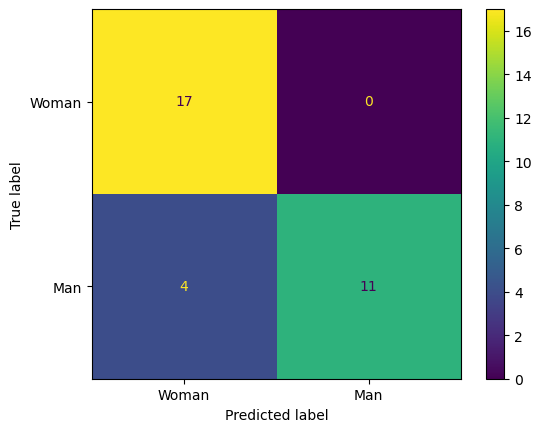

In [255]:
cm = metrics.confusion_matrix(labels_gender_test, calibrated_clf.predict(np.array([p[0] for p in predictions_gender_test])))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Woman', 'Man'])
disp.plot()

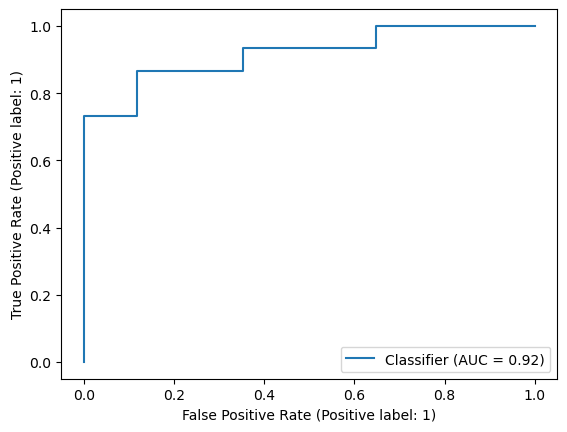

In [260]:
disp = metrics.RocCurveDisplay.from_predictions(labels_gender_test, [p[0] for p in predictions_gender_test])
disp

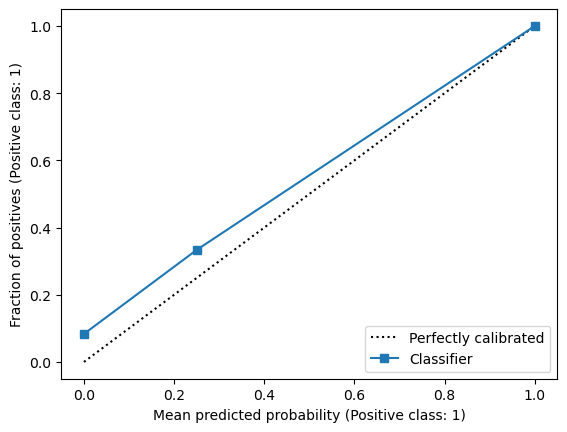

In [256]:
disp = calibration.CalibrationDisplay.from_predictions(labels_gender_test, calibrated_clf.predict_proba(np.array([p[0] for p in predictions_gender_test]))[:, 1], n_bins=5)
disp